### Simulations for the mean

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import scipy.sparse as sparse
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

/Users/mincheolkim/opt/miniconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)


In [34]:
import sys
sys.path.append('/Users/mincheolkim/Github/scrna-parameter-estimation/')
import memento
import memento.simulate as simulate

In [4]:
data_path = '/Users/mincheolkim/Data/'

### Extract parameters from interferon dataset

In [5]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')
adata = adata[adata.obs.cell_type == 'CD4 T cells - ctrl']
data = adata.X.copy()
relative_data = data.toarray()/data.sum(axis=1)

In [6]:
q = 0.07
x_param, z_param, Nc, good_idx = memento.simulate.extract_parameters(adata.X, q=q, min_mean=q)

In [7]:
x_param[0]

array([7.1957336e-05, 1.9856083e-04, 6.7119239e-05, ..., 1.9565161e-04,
       7.3280156e-05, 2.2130340e-04], dtype=float32)

### Implementing Good estimator

In [8]:
n_cells=500
n_genes = x_param[0].shape[0]

In [9]:
true_data = memento.simulate.simulate_transcriptomes(n_cells=n_cells, means=z_param[0], variances=z_param[1], Nc=Nc, norm_cov='uncorrelated')
qs, captured_data = memento.simulate.capture_sampling(true_data, 0.07, q**2+1e-7)

In [10]:
def bincount2d(arr, bins=None):
    if bins is None:
        bins = np.max(arr) + 1
    count = np.zeros(shape=[len(arr), bins], dtype=np.int64)
    indexing = (np.ones_like(arr).T * np.arange(len(arr))).T
    np.add.at(count, (indexing, arr), 1)

    return count

def bincount2d_sparse(sparse_arr, bins=None):

    bins = np.round(sparse_arr.max()).astype(int) + 1
    num_cells, num_genes = sparse_arr.shape
    count = sparse.lil_matrix((num_cells, bins))
    for cell in range(num_cells):
        cell_counts = np.bincount(np.round(sparse_arr[cell].data).astype(int))
        cell_counts[0] = num_genes - sparse_arr[cell].nnz
        count[cell, np.arange(cell_counts.shape[0])] = cell_counts
    return count

In [11]:
captured_data = sparse.csr_matrix(captured_data)

In [56]:

arr = captured_data
size_factor = arr.sum(axis=1).A1

pb = (arr.sum(axis=0).A1+1)
alpha=0.9
max_to_replace = 10
total_umi = pb.sum()
denom = np.array([total_umi - pb[sparse.find(arr[i])[1]].sum() for i in range(n_cells)]).mean()


freqs = bincount2d_sparse(arr)
expected_freqs = freqs.mean(axis=0).A1
initial_values = np.tile(np.arange(max_to_replace)[:,np.newaxis], (1,n_genes))
final_values = (initial_values + 1) * expected_freqs[initial_values+1] / expected_freqs[initial_values]
final_values[0] = (0+1) * expected_freqs[1] * (alpha*(pb/denom) + ((1-alpha)/expected_freqs[0]))

corrected_counts = sparse.csr_matrix(arr, dtype=float)
for val in range(1,max_to_replace):
    corrected_counts.data[corrected_counts.data == val] = final_values[val, 0]
    
corrected_counts = sparse.diags(1/size_factor) @ corrected_counts # normalize for size_factor
nonzero_sum = corrected_counts.sum(axis=0).A1
num_zeros_per_column = arr.shape[0] - arr.getnnz(axis=0)
zero_sum = np.array([(final_values[0, idx]/size_factor[~np.in1d(range(size_factor.shape[0]), sparse.find(arr[:, idx])[0])]).sum() for idx in range(n_genes)])
m = (nonzero_sum + zero_sum)/arr.shape[0]

In [51]:
m

array([9.08805869e-05, 2.75634520e-04, 1.10201243e-04, ...,
       2.64625514e-04, 9.27884306e-05, 2.71518244e-04])

In [16]:
arr = captured_data
pb = (arr.sum(axis=0).A1+1)
alpha=0.9


smooth_arr = arr.copy().astype(np.float64)
freqs = bincount2d_sparse(arr)
expected_freqs = freqs.mean(axis=0).A1

smooth_mask = (arr < 10)
smooth_arr[smooth_mask] = (arr[smooth_mask].A1+1)*expected_freqs[arr[smooth_mask].A1+1] / expected_freqs[arr[smooth_mask].A1]

smooth_mask = (arr == 0)
denom = np.array([pb[sparse.find(smooth_mask[i])[1]].sum() for i in range(n_cells)]).mean()

rows, cols, _ = sparse.find(smooth_mask)
smooth_arr[rows, cols] = expected_freqs[1]*(alpha*(pb[cols]/denom) + ((1-alpha)/expected_freqs[0]))
m = (smooth_arr/arr.sum(axis=1).A1[:, np.newaxis]).mean(axis=0).A1

/Users/mincheolkim/opt/miniconda3/envs/single_cell/lib/python3.7/site-packages/scipy/sparse/compressed.py:291: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)
/Users/mincheolkim/opt/miniconda3/envs/single_cell/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/mincheolkim/opt/miniconda3/envs/single_cell/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


### put in in a function

In [52]:
def _mean_only_shrink(data, n_obs, q, size_factor=None, alpha=0.9):
    """
        Hypergeometric mean estimator based on Good's estimator.
    """

    if type(data) == tuple:
        return
    else:
        
    
        smooth_arr = data.copy().astype(np.float64)
        freqs = bincount2d_sparse(data)
        expected_freqs = freqs.mean(axis=0).A1

        smooth_mask = (data < 10)
        smooth_arr[smooth_mask] = (data[smooth_mask].A1+1)*expected_freqs[data[smooth_mask].A1+1] / expected_freqs[data[smooth_mask].A1]

        smooth_mask = (data == 0)
        pb = (arr.sum(axis=0).A1+1)

        denom = np.array([pb[sparse.find(smooth_mask[i])[1]].sum() for i in range(n_obs)]).mean()

        rows, cols, _ = sparse.find(smooth_mask)
        smooth_arr[rows, cols] = expected_freqs[1]*(alpha*(pb[cols]/denom) + ((1-alpha)/expected_freqs[0]))
        m = (smooth_arr/size_factor[:, np.newaxis]).mean(axis=0).A1

        return m, np.ones(m.shape)

In [53]:
m, v = _mean_only_shrink(captured_data, n_obs=n_cells, q=q, size_factor=captured_data.sum(axis=1).A1)

/Users/mincheolkim/opt/miniconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:1: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  """Entry point for launching an IPython kernel.


In [54]:
data

<5142x35635 sparse matrix of type '<class 'numpy.float32'>'
	with 2568577 stored elements in Compressed Sparse Row format>

In [55]:
m

array([9.08805869e-05, 2.75634520e-04, 1.10201243e-04, ...,
       2.64625514e-04, 9.27884306e-05, 2.71518244e-04])

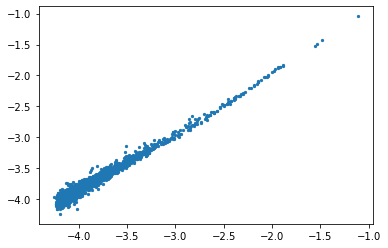

In [20]:
plt.scatter(np.log10(x_param[0]), np.log10(m), s=5)

### Try it out in the full memento codebase

In [27]:
%load_ext autoreload

In [35]:
%autoreload 2

In [58]:
adata.obs['q'] = 0.07

In [61]:
memento.setup_memento(adata, q_column='q')

In [68]:
memento.create_groups(adata, label_columns=['cell'])

In [69]:
memento.compute_1d_moments(adata)

In [76]:
adata.uns['memento']['1d_moments']['sg^CD4 T cells'][0]

[array([7.0354872e-05, 2.0055490e-04, 7.0600538e-05, ..., 1.9567333e-04,
        7.1403862e-05, 2.1235883e-04], dtype=float32),
 array([9.3322754e-09, 9.5357666e-07, 5.0630437e-08, ..., 3.0482820e-08,
        7.4649424e-09, 5.4613079e-08], dtype=float32),
 array([ 0.67086899, 19.38791847,  3.62503791, ...,  0.6392253 ,
         0.52752513,  1.03328931])]

In [ ]:

def _mean_only_shrink(data, n_obs, q, size_factor=None, alpha=0.9):
    """
        Hypergeometric mean estimator based on Good's estimator.
    """

    if type(data) == tuple:
        return
    else:
        
    
        smooth_arr = data.copy().astype(np.float64)
        freqs = bincount2d_sparse(data)
        expected_freqs = freqs.mean(axis=0).A1

        smooth_mask = (data < 10)
        smooth_arr[smooth_mask] = (data[smooth_mask].A1+1)*expected_freqs[data[smooth_mask].A1+1] / expected_freqs[data[smooth_mask].A1]

        smooth_mask = (data == 0)
        pb = (arr.sum(axis=0).A1+1)

        denom = np.array([pb[sparse.find(smooth_mask[i])[1]].sum() for i in range(n_obs)]).mean()

        rows, cols, _ = sparse.find(smooth_mask)
        smooth_arr[rows, cols] = expected_freqs[1]*(alpha*(pb[cols]/denom) + ((1-alpha)/expected_freqs[0]))
        m = (smooth_arr/size_factor[:, np.newaxis]).mean(axis=0).A1

        return m, np.ones(m.shape)